In [1]:
import os
import cv2
import torch
import numpy as np
from PIL import Image, ImageEnhance
from transformers import CLIPProcessor, CLIPModel

MODEL_DIR = "./data/models"
device = "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Thematic similarity using CLIP Model


### CLIP Model

In [2]:
print("Loading CLIP model...")
# Load the CLIP model and processor
clip_model_path = os.path.join(MODEL_DIR, "clip_model")
if os.path.exists(clip_model_path):
    # load the model weights locally
    clip_model = CLIPModel.from_pretrained(clip_model_path).to(device)
    clip_processor = CLIPProcessor.from_pretrained(clip_model_path)
else:
    clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
    clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
    # Save the model weights
    clip_model.save_pretrained(clip_model_path)
    clip_processor.save_pretrained(clip_model_path)
clip_model.eval()


Loading CLIP model...


CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

### AVA Model

In [3]:
import torchvision.transforms as transforms
from torchvision.models import resnet50


print("Loading AVA Predictor model...")
# Load the AVA model
class AVAModel(torch.nn.Module):
    def __init__(self):
        super(AVAModel, self).__init__()
        self.model = resnet50(pretrained=True).to(device)
        self.model.fc = torch.nn.Linear(self.model.fc.in_features, 1).to(device)

    def forward(self, x):
        return self.model(x).to(device)

ava_model = AVAModel()
# Save the model weights
os.makedirs(MODEL_DIR, exist_ok=True)
ava_model_path = os.path.join(MODEL_DIR, "ava_model.pt")
torch.save(ava_model.state_dict(), ava_model_path)

ava_model.load_state_dict(torch.load(ava_model_path))
ava_model.eval()

# Preprocessing transformations for AVA model
ava_processor = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

Loading AVA Predictor model...


/Users/rchaks/opt/miniforge3/envs/travel_agent/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/rchaks/opt/miniforge3/envs/travel_agent/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
# -----------------------------
# Preprocessing and quality check functions
# -----------------------------
def resize_and_normalize(image: Image, size=(1024, 1024)):
    return image.resize(size)

def is_blurry(image, threshold=100.0):
    """Check if the image is too blurry using the variance of Laplacian."""
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    laplacian_var = cv2.Laplacian(gray, cv2.CV_64F).var()
    return laplacian_var < threshold

def is_well_exposed(image, brightness_threshold=(50, 200)):
    """Check if the image brightness is within acceptable limits."""
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)
    return brightness_threshold[0] < mean_brightness < brightness_threshold[1]

def reduce_noise(image):
    """Apply noise reduction using OpenCV."""
    img_array = np.array(image)
    denoised = cv2.fastNlMeansDenoisingColored(img_array, None, 10, 10, 7, 21)
    return Image.fromarray(denoised)

def adjust_contrast(image, factor=1.5):
    """Adjust the image contrast using PIL."""
    enhancer = ImageEnhance.Contrast(image)
    return enhancer.enhance(factor)


In [5]:
import math
from matplotlib import pyplot as plt

def create_image_canvas(image_paths, title, grid_size=(10, 10)):
    img_width, img_height = 100, 100
    row_count, col_count = grid_size
    row_count = math.ceil(len(image_paths) / col_count)
    canvas_size = (img_height*col_count, img_width*row_count)
    canvas = Image.new('RGB', canvas_size, (255, 255, 255))

    for idx, img_path in enumerate(image_paths):
        if idx >= grid_size[0] * grid_size[1]:
            break
        img = Image.open(img_path)
        img = img.resize((img_width, img_height))
        x = (idx % grid_size[0]) * img_width
        y = (idx // grid_size[0]) * img_height
        canvas.paste(img, (x, y))

    plt.figure(figsize=(10, 10))
    plt.imshow(canvas)
    plt.title(title)
    plt.axis('off')
    plt.show()

In [6]:
# def compute_clip_similarity(image, text_prompt):
#     # Preprocess the image and move to the device
#     image_input = clip_processor(image).unsqueeze(0).to(device)
#     # Tokenize text prompt and move to the device
#     text_input = clip_model.tokenize([text_prompt]).to(device)
#
#     with torch.no_grad():
#         # Depending on your version, try one of the methods
#         if hasattr(clip_model, 'encode_image'):
#             image_features = clip_model.encode_image(image_input)
#         else:
#             image_features = clip_model.get_image_features(image_input)
#
#         if hasattr(clip_model, 'encode_text'):
#             text_features = clip_model.encode_text(text_input)
#         else:
#             text_features = clip_model.get_text_features(text_input)
#
#     # Normalize features
#     image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#     text_features = text_features / text_features.norm(dim=-1, keepdim=True)
#
#     # Compute cosine similarity
#     similarity = (image_features @ text_features.T).squeeze().item()
#     return similarity

In [7]:
from tqdm import tqdm

# -----------------------------
# Batch processing: Thematic filtering with CLIP and aesthetic scoring with AVA
# -----------------------------
def select_best_images_batch(image_paths, theme_prompt, top_n=5, similarity_threshold=0.2):
    """
    Processes images in batch to first filter thematically using CLIP,
    then ranks the shortlisted images with the AVA model.

    Args:
        image_paths (list): List of image file paths.
        theme_prompt (str): Text prompt describing the desired theme.
        top_n (int): Number of top images to select.
        similarity_threshold (float): Minimum cosine similarity for thematic filtering.

    Returns:
        List of tuples: (image_path, ava_score) for the top N images.
    """
    valid_paths = []
    valid_images = []
    processed_ava_images = []

    # First, apply per-image quality checks and preprocessing
    pbar = tqdm(image_paths)
    for path in pbar:
        pbar.set_description(f"Processing {os.path.basename(path)}...")
        try:
            image = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"{type(path)} Error loading {path}: {e}")
            continue

        image = resize_and_normalize(image)
        valid_paths.append(path)
        valid_images.append(image)

        # Preprocess each image using the AVA pipeline
        processed_ava_images.append(ava_processor(image))

    # Stack into a single batch tensor (shape: [N, C, H, W])
    ava_batch_tensor = torch.stack(processed_ava_images, dim=0).to(device)


    if not valid_paths:
        print("No valid images after quality checks.")
        return None, None

    # region Using CLIP to extract thematic similarity
    inputs = clip_processor(text=[theme_prompt], images=valid_images, return_tensors="pt", padding=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = clip_model(**inputs)
    # Get image and text embeddings
    image_features = outputs.image_embeds
    text_features = outputs.text_embeds

    # Normalize features
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)

    # Compute cosine similarity
    similarity = (image_features @ text_features.T).squeeze().cpu().numpy()

    # Filter images based on CLIP similarity
    filtered_indices = np.argwhere(similarity >= similarity_threshold).squeeze()
    print("Filtered indices:", len(filtered_indices))
    # endregion)

    if len(filtered_indices) == 0:
        print("No images passed the thematic filtering.")
        return None, None

    # Calculate AVA Score:
    with torch.no_grad():
        ava_scores = ava_model(ava_batch_tensor).squeeze().cpu().numpy()

    # Select top N images based on AVA scores
    top_n_indices = np.argsort(ava_scores[filtered_indices])[-top_n:]
    selected_indices = filtered_indices[top_n_indices]
    selected_paths = [valid_paths[i] for i in selected_indices.tolist()]
    selected_ava_scores = [ava_scores[i] for i in selected_indices.tolist()]

    return selected_paths, selected_ava_scores

In [8]:
# Number of top images to select
top_n = 25
theme = "A brown dog being pet"
# theme = "Stunning, colourful and vibrant slot canyons of the lower antelope canyons in arizona"

# Example usage
image_dir = "./data/x"
image_paths = [os.path.join(image_dir, path) for path in os.listdir(image_dir) if path.endswith(('.png', '.jpg', '.jpeg'))]

print(f"Total images: {len(image_paths)}")

img_paths, scores  = select_best_images_batch(
    image_paths,
    theme_prompt=theme,
    top_n=top_n, similarity_threshold=0.25
)

# Separate passed and failed images
dissimilar_images = list(set(image_paths) - set(img_paths))

Total images: 68


Processing B31E4DE0-F793-4CA2-93CB-26036E19CD5D_1_105_c.jpeg...: 100%|██████████| 68/68 [00:01<00:00, 60.35it/s]  


Filtered indices: 2


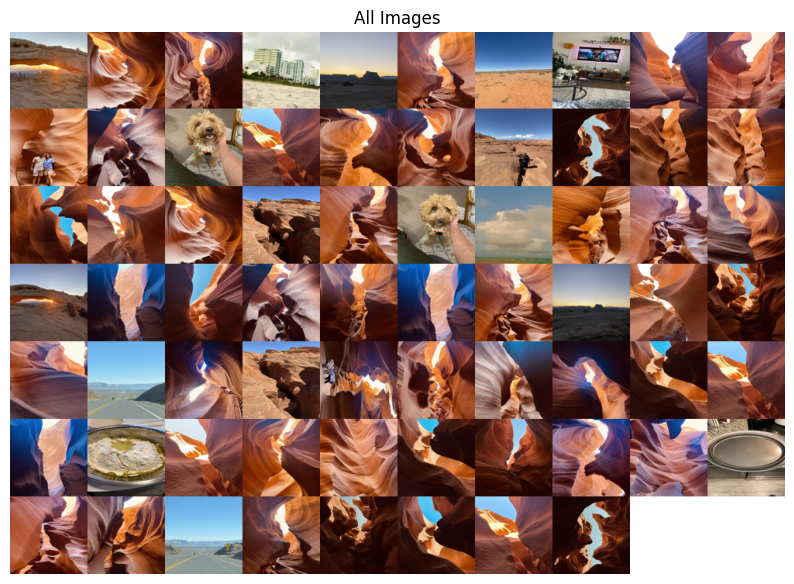

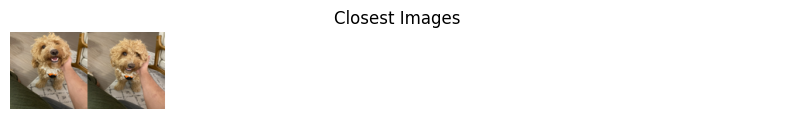

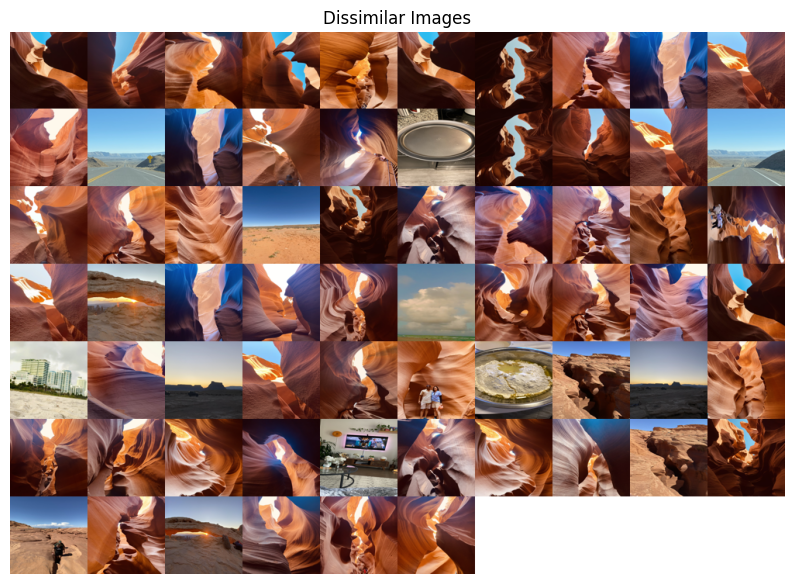

In [9]:
# Create canvases
create_image_canvas(image_paths, "All Images")
create_image_canvas(img_paths, "Closest Images")
create_image_canvas(dissimilar_images, "Dissimilar Images")

---